In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

# To visualize the data
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.base.tsa_model import get_prediction_index
from sklearn import metrics


In [2]:
df2 = pd.read_csv('NYC_Energy_Consumption.csv',index_col = False)
#df2.columns = df2.columns.str.lower()
df2.info()
df2.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49204 entries, 0 to 49203
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0       timeStamp  49204 non-null  object 
 1   demand         49123 non-null  float64
 2   precip         48974 non-null  float64
 3   temp           49018 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


,timeStamp,demand,precip,temp
0,2012-01-01 01:00:00,4752.100,0.0000,45.89
1,2012-01-01 02:00:00,4542.600,0.0000,45.04
2,2012-01-01 03:00:00,4357.700,0.0000,45.03
3,2012-01-01 04:00:00,4275.500,0.0000,42.61
4,2012-01-01 05:00:00,4274.700,0.0000,39.02
...,...,...,...,...
49118,2017-08-10 01:00:00,5714.258,0.0213,71.06
49119,2017-08-10 02:00:00,5497.025,0.0068,71.21
49120,2017-08-10 03:00:00,5360.583,0.0070,70.39
49121,2017-08-10 04:00:00,5333.775,0.0030,69.18


In [3]:

df2.rename(columns = {'    timeStamp' : 'timeStamp'}, inplace = True)
df2['timeStamp'] = pd.to_datetime(df2['timeStamp']).dt.date
df2['timeStamp'] = pd.to_datetime(df2['timeStamp'])
df2

,timeStamp,demand,precip,temp
0,2012-01-01,4752.1,0.0000,45.89
1,2012-01-01,4542.6,0.0000,45.04
2,2012-01-01,4357.7,0.0000,45.03
3,2012-01-01,4275.5,0.0000,42.61
4,2012-01-01,4274.7,0.0000,39.02
...,...,...,...,...
49199,2017-08-12,NaN,0.0000,70.84
49200,2017-08-12,NaN,0.0000,70.57
49201,2017-08-12,NaN,0.0000,69.89
49202,2017-08-12,NaN,0.0000,68.59


In [33]:
df2['demand'] = df2['demand'].fillna(method = 'ffill')
df2['temp'] = df2['temp'].fillna(method = 'ffill')

In [34]:
df_nyc = df2.groupby('timeStamp')['demand'].sum().to_frame()

In [35]:
df_nyc

,demand
timeStamp,
2012-01-01,113978.500
2012-01-02,127270.900
2012-01-03,146292.300
2012-01-04,152070.400
2012-01-05,147125.900
...,...
2017-08-08,155319.025
2017-08-09,163466.692
2017-08-10,133118.076


In [36]:
df_nyc_monthly = df_nyc.resample('M').mean()
df_nyc_monthly



,demand
timeStamp,
2012-01-31,138020.625806
2012-02-29,134935.958621
2012-03-31,131518.060742
2012-04-30,128854.700000
2012-05-31,140829.506452
...,...
2017-04-30,125603.457167
2017-05-31,130122.553452
2017-06-30,158351.768300


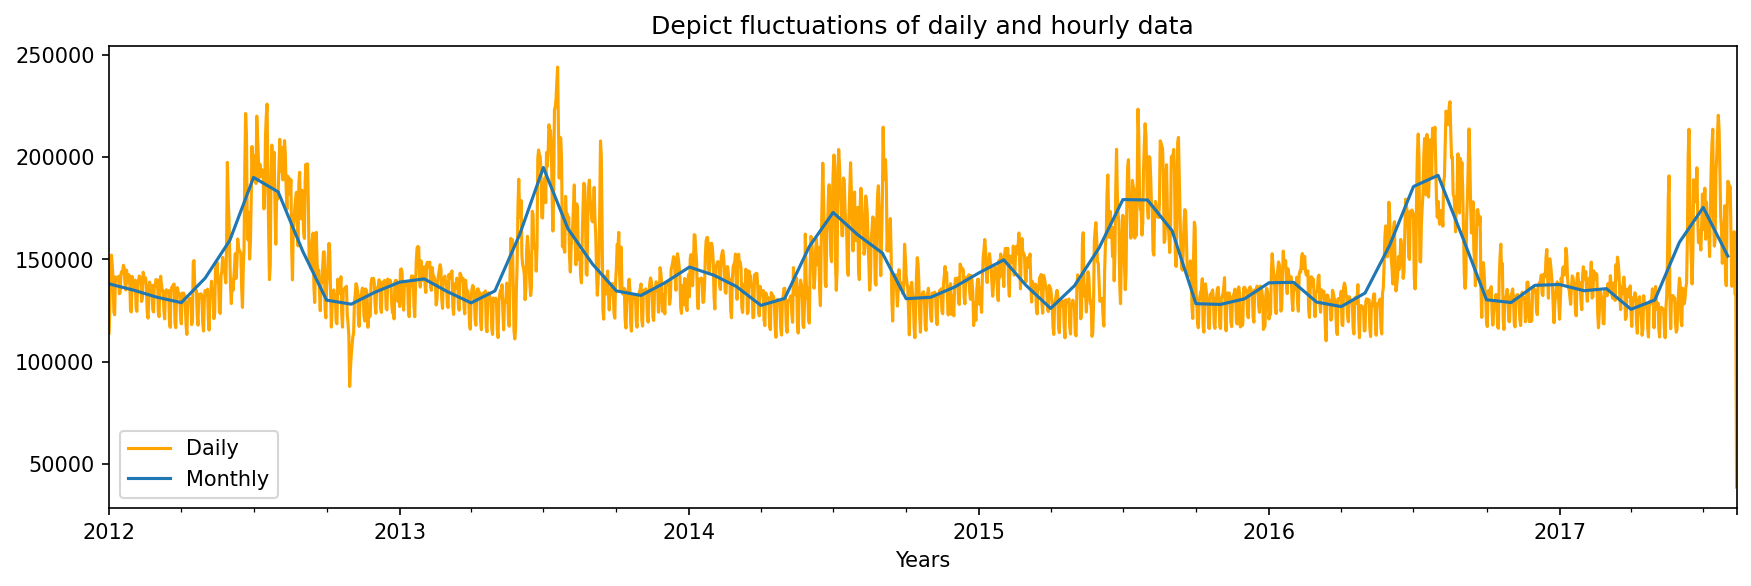

In [37]:
plt.figure(figsize=(14,4 ), dpi=150)
  

df_nyc['demand'].plot(label='Daily', color='orange')
df_nyc_monthly['demand'].plot(label='Monthly')
  
plt.title('Depict fluctuations of daily and hourly data')
  
# adding Label to the x-axis
plt.xlabel('Years')
  
# adding legend to the curve
plt.legend()

In [38]:

train = df_nyc_monthly[(df_nyc_monthly.index.get_level_values(0) >= '2012-01-31') & 
                      (df_nyc_monthly.index.get_level_values(0) < '2017-04-30')]

test = df_nyc_monthly[(df_nyc_monthly.index.get_level_values(0) >= '2017-04-30')]
df_nyc_monthly

,demand
timeStamp,
2012-01-31,138020.625806
2012-02-29,134935.958621
2012-03-31,131518.060742
2012-04-30,128854.700000
2012-05-31,140829.506452
...,...
2017-04-30,125603.457167
2017-05-31,130122.553452
2017-06-30,158351.768300


In [39]:
result = adfuller(df_nyc_monthly['demand'])
result

(-8.446589866320663,
 1.7062711357418697e-13,
 8,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 1161.3245304104469)

In [40]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#d = 0

ADF Statistic: -8.446590
p-value: 0.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


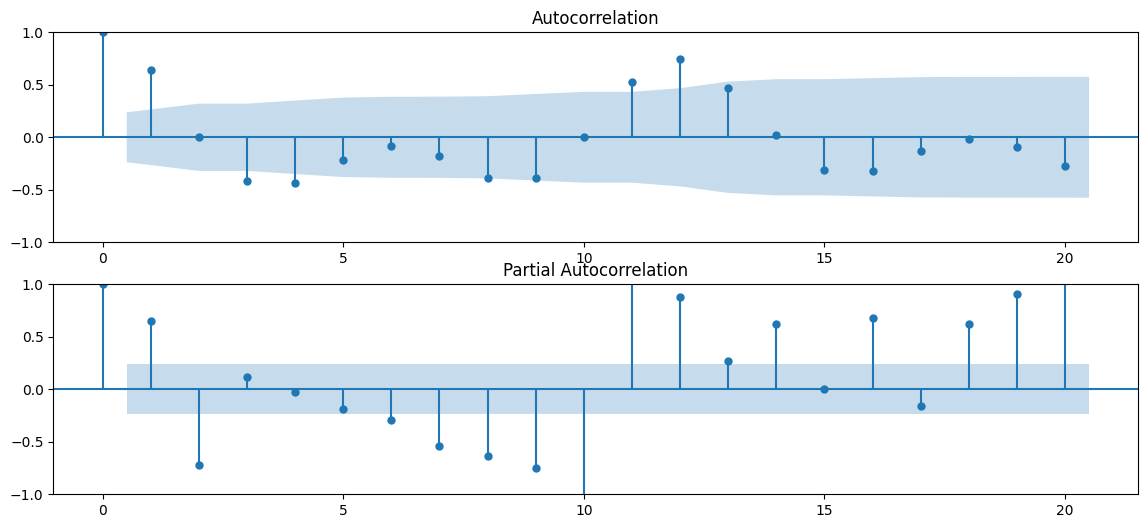

In [41]:
fig, ax = plt.subplots(nrows=2, figsize=(14,6))
plot_acf(df_nyc_monthly['demand'], lags=20, ax=ax[0])
plot_pacf(df_nyc_monthly['demand'], lags=20, ax=ax[1])
plt.show()
#p=2
#q = 3

In [42]:
modelArimaNewParam = ARIMA(train['demand'],order = (2,0,3), freq='M')

In [43]:
arimaPred_newparameters = modelArimaNewParam.fit()
#forecast_Arima_dfmonthly = modelArimaNewParam.predict(start = '2020-06-30', end = '2020-10-31',params=newparams)
forecast_Arima_dfmonthly = arimaPred_newparameters.forecast(steps=5)
forecast_Arima_dfmonthlyPD = forecast_Arima_dfmonthly.to_frame(name = 'Prediction' )
forecast_Arima_dfmonthlyPD

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,Prediction
2017-04-30,143657.747806
2017-05-31,151514.036436
2017-06-30,154904.953573
2017-07-31,153080.781005
2017-08-31,148681.278091


In [44]:
np.sqrt(np.sum(((forecast_Arima_dfmonthlyPD['Prediction'] - test['demand']) / test['demand'])**2)) / 5

0.05086134499205304

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


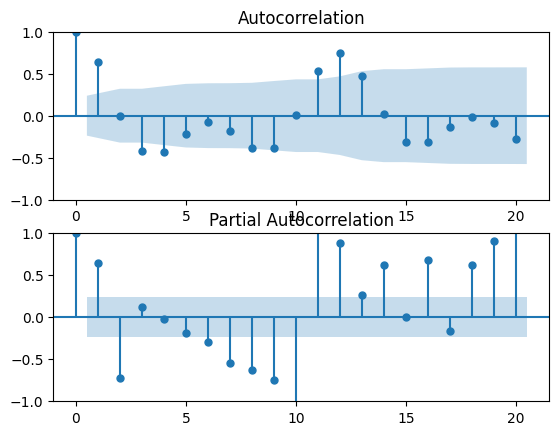

In [45]:
fig, ax = plt.subplots(2,1)
fig = plot_acf(df_nyc_monthly['demand'], lags=20, ax=ax[0])
fig = plot_pacf(df_nyc_monthly['demand'], lags=20, ax=ax[1])
plt.show()
#d = D = 0
# s= 12
# P = 0
# Q = 0


In [46]:
D = 0
result = adfuller(df_nyc_monthly['demand'], autolag='AIC')
while result[1] > 0.05:
    D += 1
    df_seasonal_diff = np.diff(df_nyc_monthly['demand'], n=D, axis=0)
    result = adfuller(df_seasonal_diff, autolag='AIC')
print(f'D: {D}')

D: 0


In [47]:
modelSArimaNewParam = SARIMAX(train['demand'], order=(2, 0, 3), seasonal_order=(0, 0, 0, 12))


In [48]:

results = modelSArimaNewParam.fit()
forecast_SArima_dfmonthly = results.forecast(steps=5)
forecast_SArima_dfmonthlyPD = forecast_SArima_dfmonthly.to_frame(name = 'Prediction' )
forecast_SArima_dfmonthlyPD

,Prediction
2017-04-30,139625.279274
2017-05-31,142738.968188
2017-06-30,144234.478531
2017-07-31,144636.208613
2017-08-31,144743.607331


In [49]:
np.sqrt(np.sum(((forecast_SArima_dfmonthlyPD['Prediction'] - test['demand']) / test['demand'])**2)) / 5

0.05001819025942946

In [50]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
%%time
import pmdarima as pm
# Auto Arima performs Grid Search CV Test
model = pm.auto_arima(df_nyc_monthly['demand'], 
#                       Monthly basis
                      m = 12,
#                       Data is Seasonal
                      seasonal = True,
#                       P, Q starting value
                      start_p = 0,
                      start_q = 0,
                      max_order = 4,
#                       Tests seasonality and gives I or D value
                      test = 'adf',
                      error_action = 'ignore',
                      suppress_warnings = True,
#                       Performs random search
                      stepwise = True,
                      trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1506.003, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1531.966, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1472.587, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1470.331, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1812.829, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1486.951, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1472.232, Time=0.57 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1487.946, Time=0.12 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1470.312, Time=0.39 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1501.969, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=1444.108, Time=0.49 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept

In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   68
Model:             SARIMAX(2, 0, 3)x(1, 0, [], 12)   Log Likelihood                -708.139
Date:                             Sat, 29 Apr 2023   AIC                           1432.277
Time:                                     03:03:30   BIC                           1450.033
Sample:                                 01-31-2012   HQIC                          1439.313
                                      - 08-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.708e+05    5.4e+04      3.165      0.002     6.5e+04    2.77e+05
ar.L1         -1.5517      0.256     -6.057      0.000      -2.054      -1.050
ar.L2         -0.7539      0.243     -3.103      0.002      -1.230      -0.278
ma.L1          2.4609      0.282      8.724      0.000       1.908       3.014
ma.L2          2.3124      0.481      4.809      0.000       1.370       3.255
ma.L3          0.7959      0.241      3.306      0.001       0.324       1.268
ar.S.L12       0.6449      0.109      5.910      0.000       0.431       0.859
sigma2      7.619e+07     37.920   2.01e+06      0.000    7.62e+07    7.62e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                11.07
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.61
Prob(H) (two-sided):                  0.45   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+26. Standard errors may be unstable.
"""

In [53]:
model.fit(train['demand'])

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True)

In [54]:
forecast = model.predict(n_periods = 5, return_conf_int = True)

In [55]:
forecast_df = pd.DataFrame(forecast[0], index = test.index,columns = ['Prediction'])

In [56]:
forecast_df['Prediction']

timeStamp
2017-04-30    136198.280074
2017-05-31    139257.397860
2017-06-30    152246.788463
2017-07-31    170676.628400
2017-08-31    173408.929300
Freq: M, Name: Prediction, dtype: float64

In [57]:
np.sqrt(np.sum(((forecast_df['Prediction'] - df_nyc_monthly.tail()['demand']) / df_nyc_monthly.tail()['demand'])**2)) / 5

0.03741601591880129